# Research question: What is the relationship between the SHAP and feature value?
[not including the hospital feature]

## Plain English summary

When fitting a machine learning model to data to make a prediction, it is now possible, with the use of the SHAP library, to allocate contributions of the prediction onto the feature values. This means that we can now turn these black box methods into transparent models and describe what the model used to obtain it's prediction.

SHAP values are calculated for each feature of each instance for a fitted model. In addition there is the SHAP base value which is the same value for all of the instances. The base value represents the models best guess for any instance without any extra knowledge about the instance (this can also be thought of as the "expected value"). It is possible to obtain the models prediction of an instance by taking the sum of the SHAP base value and each of the SHAP values for the features. This allows the prediction from a model to be transparant, and we can rank the features by their importance in determining the prediction for each instance.

In our previous notebook (03_xgb_combined_shap_key_features.ipynb) we looked at SHAP values for all the features (fitting models to k-fold data and comparing the differences of the SHAP values obtained across the 5 models). 

In our previous notebook (03a_xgb_combined_shap_key_features.ipynb) we fited a single model to all of the data (no test set) and focused on understanding the SHAP values for each of the one-hot encoded hosptial features that make up the *Stroke team* categorical feature.

In this notebook we will use the model from notebook 03a (all data model) and focus on understanding the relationship between the SHAP and feature values for the other 9 features.

SHAP values are in the same units as the model output (for XGBoost these are in log odds). 

Here we read in an already fitted XGBoost model to the SAMueL dataset (and the SHAP values), to predict whether a patient recieves thrombolysis from the values of 10 features, using all data to train (no test set). We explore the relationship between SHAP values adn feature values for 9 features (not the hospital feature).

## Model and data

XGBoost model was trained on all of the data (no test set used). The 10 features in the model are:

* Arrival-to-scan time: Time from arrival at hospital to scan (mins)
* Infarction: Stroke type (1 = infarction, 0 = haemorrhage)
* Stroke severity: Stroke severity (NIHSS) on arrival
* Precise onset time: Onset time type (1 = precise, 0 = best estimate)
* Prior disability level: Disability level (modified Rankin Scale) before stroke
* Stroke team: Stroke team attended
* Use of AF anticoagulents: Use of atrial fibrillation anticoagulant (1 = Yes, 0 = No)
* Onset-to-arrival time: Time from onset of stroke to arrival at hospital (mins)
* Onset during sleep: Did stroke occur in sleep?
* Age: Age (as middle of 5 year age bands)

And one target feature:
* Thrombolysis: Did the patient receive thrombolysis (0 = No, 1 = Yes)

## Aims

* Fit XGBoost model using feature data (no test set) to predict whether patient gets thrombolysis
* Calculate the SHAP values of the features
* Understand the relationship between the SHAP value and feature values for all features (apart from the hospital feature)

## Observations
* Stroke type: The SHAP values for stroke type show that the model effectively eliminated any probability of receiving thrombolysis for non-ischaemic (haemorrhagic) stroke.
*  Arrival-to-scan time: The odds of receiving thrombolysis reduced by about 20 fold over the first 100 minutes of arrival to scan time.
* Stroke severity (NIHSS): The odds of receiving thrombolysis were lowest at NIHSS 0, increased and peaked at NIHSS 15-25, and then fell again with higher stroke severity (NIHSS above 25). The difference between minimum odds (at NIHSS 0) and maximum odds (at 15-25) of receiving thrombolysis was 30-35 fold.
* Stroke onset time type (precise vs. estimated): The odds of receiving thrombolysis were about 3 fold greater for precise onset time than estimated onset time.
* Disability level (mRS) before stroke: The odds of receiving thrombolysis fell about 5 fold between mRS 0 and 5.

### Extra code to check something for the paper

In notebook 03_xgb_combined_shap_key_features.ipynb we used the training set from the first kfold to plot the feature value vs SHAP for the top 6 influencial features.

Here we use the 'all data model', and look at all features to inform the subgroup analysis (to include all features for that too, rather than the selected 3 features)

## Show the relationship between feature value and SHAP value for all the features

## Import modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Import machine learning methods
from xgboost import XGBClassifier

# Import shap for shapley values
import shap # `pip install shap` if neeed

# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

from scipy import stats
from sklearn import linear_model

import os
import pickle

import math # to .floor and .ceil

# So can take deep copy
import copy

from os.path import exists
import json

/home/michael/miniconda3/envs/samuel/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Set filenames

In [2]:
# Set model type (used in file save, e.g. xgb_combined_calibrated_oversampled)
number_of_features_to_use = 10
model_text = f'xgb_{number_of_features_to_use}_features'
notebook = '03d'

## Create output folders if needed

In [3]:
path = './saved_models'
if not os.path.exists(path):
    os.makedirs(path)

path = './output'
if not os.path.exists(path):
    os.makedirs(path)
    
path = './predictions'
if not os.path.exists(path):
    os.makedirs(path)   

## Read in JSON file

Contains a dictionary for plain English feature names for the 8 features selected in the model. Use these as the column titles in the DataFrame.

In [4]:
with open("./output/01_feature_name_dict.json") as json_file:
    dict_feature_name = json.load(json_file)

## Load data

Data has previously been split into 5 stratified k-fold splits.

For this exercise, we will fit a model using all of the data (rather than train/test splits used to assess accuracy). We will join up all of the test data (by definition, each instance exists only once across all of the 5 test sets)

In [5]:
data_loc = '../data/kfold_5fold/'

In [6]:
# Initialise empty list
test_data_kfold = []

# Read in the names of the selected features for the model
key_features = pd.read_csv('./output/01_feature_selection.csv')
key_features = list(key_features['feature'])[:number_of_features_to_use]
# And add the target feature name: S2Thrombolysis
key_features.append('S2Thrombolysis')

# For each k-fold split
for i in range(5):
    # Read in test set, restrict to chosen features, rename titles, & store
    test = pd.read_csv(data_loc + 'test_{0}.csv'.format(i))
    test = test[key_features]
    test.rename(columns=dict_feature_name, inplace=True)
    test_data_kfold.append(test)

# Join all the test sets. Set "ignore_index = True" to reset the index in the
#   new dataframe (to run from 0 to n-1), otherwise get duplicate index values
data = pd.concat(test_data_kfold, ignore_index=True)

## Get list of feature names

In [7]:
feature_names = list(test_data_kfold[0])

## Edit data
### Divide into X (features) and y (labels)
We will separate out our features (the data we use to make a prediction) from our label (what we are trying to predict).
By convention our features are called `X` (usually upper case to denote multiple features), and the label (thrombolysis or not) `y`.

In [8]:
X_data = data.drop('Thrombolysis', axis=1)
y = data['Thrombolysis']

Average thromboylsis (this is the expected outcome of each patient, without knowing anything about the patient)

In [9]:
print (f'Average treatment: {round(y.mean(),2)}')

Average treatment: 0.3


### One-hot encode hospital feature

In [10]:
# Keep copy of original, with 'Stroke team' not one-hot encoded
X_combined = X_data.copy(deep=True)

# One-hot encode 'Stroke team'
X_hosp = pd.get_dummies(X_data['Stroke team'], prefix = 'team')
X_data = pd.concat([X_data, X_hosp], axis=1)
X_data.drop('Stroke team', axis=1, inplace=True)

In [11]:
# get feature names
feature_names_ohe = list(X_data)

## Load XGBoost model

An XGBoost model was trained on the full dataset (rather than train/test splits used to assess accuracy) in notebook 03a_xgb_shap_values_focus_on_ohe_hospitals.ipynb

In [12]:
# Load models
filename = (f'./saved_models/03a_{model_text}.p')
with open(filename, 'rb') as filehandler:
    model = pickle.load(filehandler)
        
# Get the predictions for each patient 
#   (the classification, and the probability of being in either class)
y_pred = model.predict(X_data)
y_pred_proba = model.predict_proba(X_data)

# Calculate the models accuracy
accuracy = np.mean(y == y_pred)
print(f'Model accuracy: {accuracy:0.3f}')

Model accuracy: 0.878


## SHAP values

SHAP values give the contribution that each feature has on the models prediction, per instance. A SHAP value is returned for each feature, for each instance.

We will use the shap library: https://shap.readthedocs.io/en/latest/index.html

'Raw' SHAP values from XGBoost model are log odds ratios.

### Get SHAP values

TreeExplainer is a fast and exact method to estimate SHAP values for tree models and ensembles of trees.
Using this we can calculate the SHAP values.

Either load from pickle (if file exists), or calculate.

In [13]:
%%time
# Set up method to estimate SHAP values for tree models and ensembles of trees

filename = f'./output/03a_{model_text}_shap_explainer_object.p'
file_exists = exists(filename)

if file_exists:
    # Load SHAP interaction
    with open(filename, 'rb') as filehandler:
        explainer = pickle.load(filehandler)
else:
    print("Run notebook 03a")
    
# Get SHAP values
filename = f'./output/03a_{model_text}_shap_values_explainer_object.p'
file_exists = exists(filename)

if file_exists:
    # Load explainer
    with open(filename, 'rb') as filehandler:
        shap_values_extended = pickle.load(filehandler)
else:
    print("Run notebook 03a")

CPU times: user 7.27 ms, sys: 51.3 ms, total: 58.5 ms
Wall time: 58.2 ms


The explainer returns the base value which is the same value for all instances [shap_value.base_values], the shap values per feature [shap_value.values]. It also returns the feature dataset values [shap_values.data]. You can (sometimes!) access the feature names from the explainer [explainer.data_feature_names].

Let's take a look at the data held for the first instance:
* .values has the SHAP value for each of the four features.
* .base_values has the best guess value without knowing anything about the instance.
* .data has each of the feature values

In [14]:
shap_values_extended[0]

.values =
array([ 7.56502628e-01,  4.88319576e-01,  1.10273695e+00,  4.40223962e-01,
        4.98975307e-01,  2.02812225e-01, -2.62601525e-01,  3.69181409e-02,
        2.30234995e-01,  3.20923195e-04, -6.03703642e-03, -7.17267860e-04,
        0.00000000e+00, -4.91688668e-04,  1.20360847e-03,  1.77788886e-03,
       -4.34198463e-03, -2.76021136e-04, -2.79896380e-03,  3.52182891e-03,
       -2.73969141e-04,  8.53505917e-03, -5.28220041e-03, -8.25227005e-04,
        6.20208494e-03,  6.92215608e-03, -6.32244349e-03, -3.35367222e-04,
        7.81939551e-03, -4.71850217e-06, -4.25534381e-05,  6.48253039e-03,
        8.43156071e-04, -6.28353562e-04, -1.25156669e-02, -7.92063680e-03,
       -1.99409085e-03, -5.05548809e-03, -3.90118686e-03,  1.30317558e-03,
        0.00000000e+00, -6.48246554e-04,  1.19629130e-03,  8.26304778e-04,
        1.28053436e-02,  2.55714403e-03, -3.20375757e-03,  4.23251512e-03,
       -7.19791185e-03,  4.02670400e-03,  3.75146419e-03,  8.31848301e-04,
        3.45067

## Create order of features to include in the violin plots

Rank features by SHAP value

Taking the mean |SHAP| for each feature (across all patients), rank the features by SHAP value

#### Get average SHAP values for each feature (across all the patients)

Calculate the mean SHAP value for each feature (across all instances), in three ways:
* mean of raw values
* mean of absolute values
* absolute of mean of raw values

In [15]:
# Get SHAP values
shap_values = shap_values_extended.values

# Calculate mean SHAP value for each feature (across all instances)
df_shap_values_mean = pd.DataFrame(index=feature_names_ohe)
df_shap_values_mean['mean_shap'] = np.mean(shap_values, axis=0)
df_shap_values_mean['abs_mean_shap'] = np.abs(df_shap_values_mean['mean_shap'])
df_shap_values_mean['mean_abs_shap'] = np.mean(np.abs(shap_values), axis=0)
df_shap_values_mean['rank'] = df_shap_values_mean['mean_abs_shap'].rank(
    ascending=False).values
df_shap_values_mean.sort_values('rank', inplace=True, ascending=True)
df_shap_values_mean.head(10)

,mean_shap,abs_mean_shap,mean_abs_shap,rank
Infarction,-0.974695,0.974695,1.540489,1.0
Arrival-to-scan time,-0.385795,0.385795,0.991457,2.0
Stroke severity,-0.196834,0.196834,0.915676,3.0
Precise onset time,-0.061659,0.061659,0.538988,4.0
Prior disability level,-0.005883,0.005883,0.387559,5.0
Use of AF anticoagulants,-0.041382,0.041382,0.310106,6.0
Onset-to-arrival time,-0.066359,0.066359,0.291748,7.0
Age,-0.014048,0.014048,0.167593,8.0
Onset during sleep,-0.024299,0.024299,0.102481,9.0
team_VKKDD9172T,-0.005500,0.005500,0.029842,10.0


Take first 9 features (assuming that all of the teams one-hot encoded features are ranked below the other features.

In [16]:
features_shap_ranked = list(df_shap_values_mean.head(9).index)

### Show the relationship between feature value and SHAP value for all of the features
(as violin plots)

Resource: 
https://towardsdatascience.com/binning-records-on-a-continuous-variable-with-pandas-cut-and-qcut-5d7c8e11d7b0
https://matplotlib.org/3.1.0/gallery/statistics/customized_violin.html

In [17]:
def set_ax(ax, category_list, feat, rotation=0):
    '''
    ax [matplotlib axis object] = matplotlib axis object
    category_list [list] = used for the xtick labels (the grouping of the data)
    rotation [integer] = xtick label rotation
    feat [string] = used in the axis label, the feature that is being plotted
    
    resource: 
    https://matplotlib.org/3.1.0/gallery/statistics/customized_violin.html
    '''
    # Set the axes ranges and axes labels
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(category_list) + 1))
    ax.set_xticklabels(category_list, rotation=rotation, fontsize=10)
    ax.set_xlim(0.25, len(category_list) + 0.75)
    ax.set_ylabel(f'SHAP values for {feat}', fontsize=12)
    ax.set_xlabel(f'Feature values for {feat}', fontsize=12)
    return(ax)

Stroke type: The SHAP values for stroke type show that the 
model effectively eliminated any probability of receiving 
thrombolysis for non-ischaemic (haemorrhagic) stroke. The 
odds of receiving thrombolysis fell about 6402.03 
fold.

Arrival-to-scan time: The odds of receiving thrombolysis reduced by 
about 9.68 (20) fold over the first 120 minutes of arrival to scan time.

Stroke severity (NIHSS): The odds of receiving thrombolysis were lowest
 at NIHSS 0, increased and peaked at NIHSS 15-25, and then fell again 
with higher stroke severity (NIHSS above 25). The difference between 
minimum odds (at NIHSS 0) and maximum odds (at 15-25) of receiving 
thrombolysis was 26.69 (30-35) fold.

Stroke onset time type (precise vs. estimated): The odds of receiving 
thrombolysis were about 3.24 (3) fold greater for precise onset time than 
estimated onset time.

Disability level (mRS) before stroke: The odds of receiving 
thrombolysis fell about 6.48 (5) fold between mRS 0 and 5.

Use of AF an

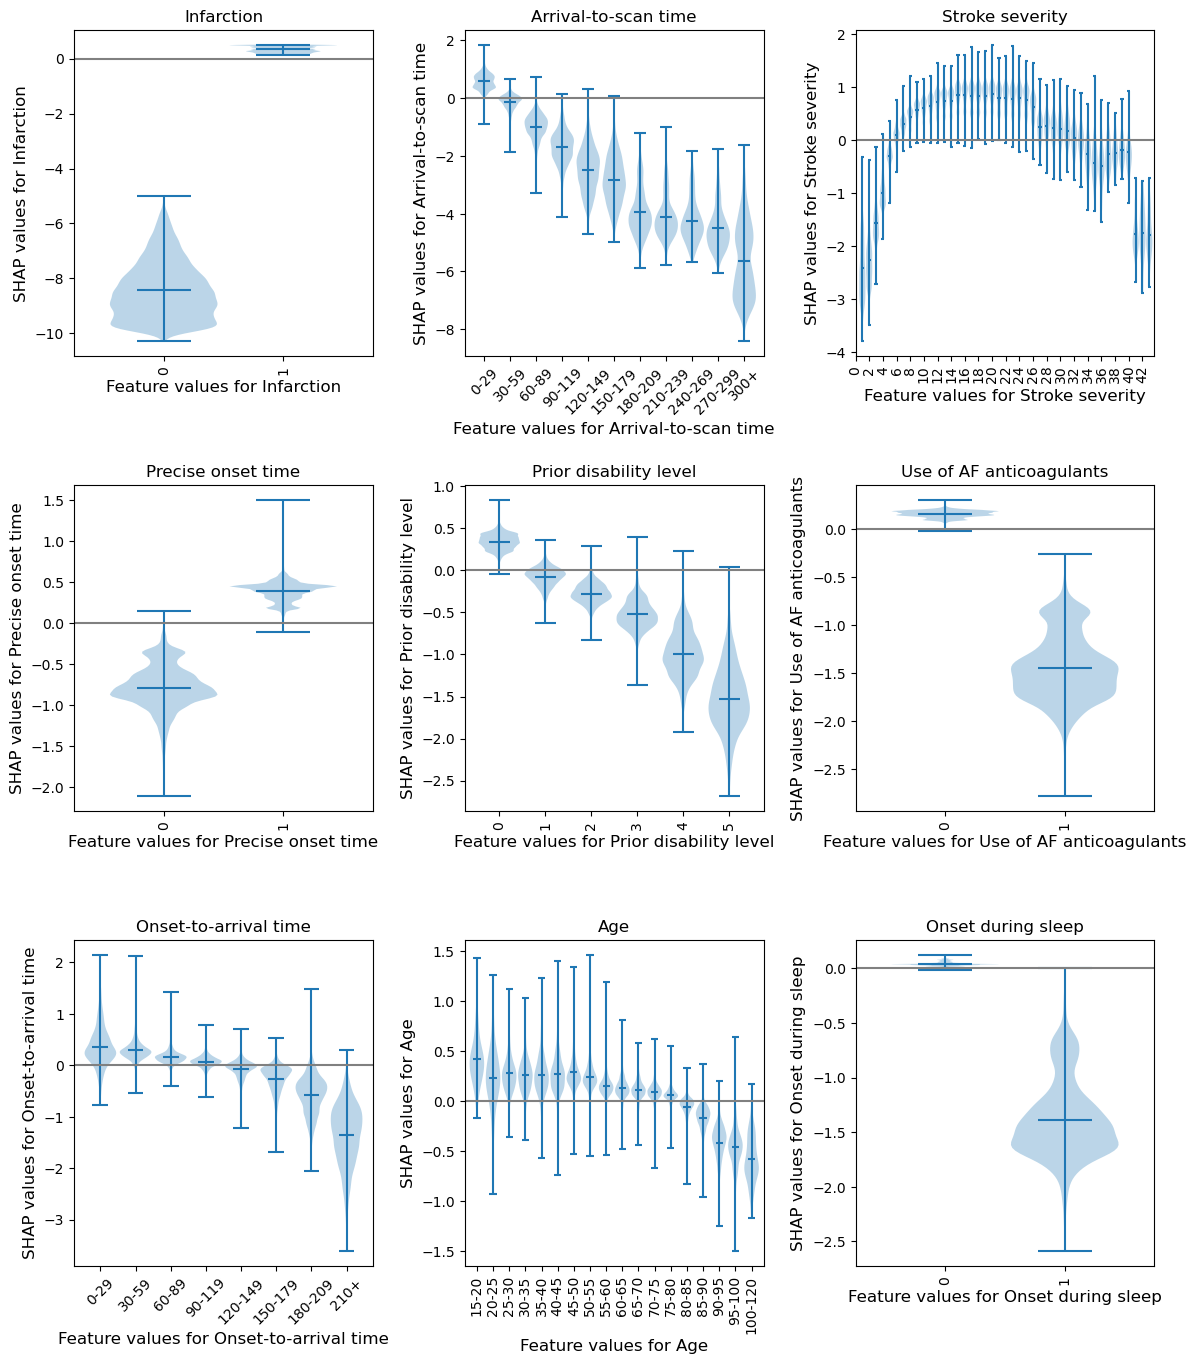

In [18]:
# Feature Age needs special consideration. It needs the x ticks to be created,
# as the other features with over 50 unique values, but age is already grouped 
# for the model (into 5yr groups) and so is treated as the other type.

fig = plt.figure(figsize=(12,14), constrained_layout=True)
# for each feature, prepare the data for the violin plot.
# data either already in categories, or if there's more than 50 unique values
# for a feature then assume it needs to be binned, and a violin for each bin
for n, feat in enumerate(features_shap_ranked):    
    feature_data = shap_values_extended[:, feat].data
    feature_shap = shap_values_extended[:, feat].values

    # if feature has more that 50 unique values, then assume it needs to be 
    # binned (other assume they are unique categories)
    if np.unique(feature_data).shape[0] > 50:
        # bin the data, create a violin per bin
        
        # settings for the plot
        rotation = 45
        step = 30
        n_bins = min(11, np.int((feature_data.max())/step))
        
        # create list of bin values
        bin_list = [(i*step) for i in range(n_bins)]
        bin_list.append(feature_data.max())

        # create list of bins (the unique categories)
        category_list = [f'{i*step}-{((i+1)*step-1)}' for i in range(n_bins-1)]
        category_list.append(f'{(n_bins-1)*step}+')

        # bin the feature data
        feature_data = pd.cut(feature_data, bin_list, labels=category_list, 
                              right=False)

    else:
        # create a violin per unique value
        
        # settings for the plot
        rotation = 90
        
        # create list of unique categories in the feature data
        # Age needs to keep its decimal value (midpoint between 5 yrs)
        category_list = np.unique(feature_data)
        if feat != 'Age':
            category_list = [int(i) for i in category_list]

    # create a list, each entry contains the corresponsing SHAP value for that 
    # category (or bin). A violin will represent each list.    
    shap_per_category = []
    for category in category_list:
        mask = feature_data == category
        shap_per_category.append(feature_shap[mask])

    if feat == "Infarction":
        range_shap_log_odds = np.mean(shap_per_category[1]) - np.mean(shap_per_category[0])
        odds = math.exp(range_shap_log_odds)
        print(f"Stroke type: The SHAP values for stroke type show that the \n"
              f"model effectively eliminated any probability of receiving \n"
              f"thrombolysis for non-ischaemic (haemorrhagic) stroke. The \n"
              f"odds of receiving thrombolysis fell about {round(odds,2)} \n"
              f"fold.\n")    
    if feat == "Arrival-to-scan time":
        range_shap_log_odds = np.mean(shap_per_category[0]) - np.mean(shap_per_category[3])
        odds = math.exp(range_shap_log_odds)
        print(f"Arrival-to-scan time: The odds of receiving thrombolysis reduced by \n"
        f"about {round(odds,2)} (20) fold over the first 120 minutes of arrival to scan time.\n")    
    if feat == "Stroke severity":
        range_shap_log_odds = np.mean(shap_per_category[19]) - np.mean(shap_per_category[0])
        odds = math.exp(range_shap_log_odds)
        print(f"Stroke severity (NIHSS): The odds of receiving thrombolysis were lowest\n"
          f" at NIHSS 0, increased and peaked at NIHSS 15-25, and then fell again \n"
          f"with higher stroke severity (NIHSS above 25). The difference between \n"
          f"minimum odds (at NIHSS 0) and maximum odds (at 15-25) of receiving \n"
          f"thrombolysis was {round(odds,2)} (30-35) fold.\n")
    if feat == "Precise onset time":
        range_shap_log_odds = np.mean(shap_per_category[1]) - np.mean(shap_per_category[0])
        odds = math.exp(range_shap_log_odds)
        print(f"Stroke onset time type (precise vs. estimated): The odds of receiving \n"
          f"thrombolysis were about {round(odds,2)} (3) fold greater for precise onset time than \n"
          f"estimated onset time.\n")
    if feat == "Prior disability level":
        range_shap_log_odds = np.mean(shap_per_category[0]) - np.mean(shap_per_category[5])
        odds = math.exp(range_shap_log_odds)
        print(f"Disability level (mRS) before stroke: The odds of receiving \n"
        f"thrombolysis fell about {round(odds,2)} (5) fold between mRS 0 and 5.\n")
    if feat == "Use of AF anticoagulants":
        range_shap_log_odds = np.mean(shap_per_category[0]) - np.mean(shap_per_category[1])
        odds = math.exp(range_shap_log_odds)
        print(f"Use of AF anticoagulants: The odds of receiving thrombolysis were about\n"
        f" {round(odds,2)} fold greater for no use.\n")
    if feat == "Onset-to-arrival time":
        range_shap_log_odds = np.mean(shap_per_category[4]) - np.mean(shap_per_category[7])
        odds = math.exp(range_shap_log_odds)
        print(f"Onset-to-arrival time: The odds of receiving thrombolysis were similar \n"
        f"below 120 minutes, then fell about {round(odds,2)} fold between 120 and above.\n")
    if feat == "Age":
        range_shap_log_odds = np.mean(shap_per_category[13]) - np.mean(shap_per_category[17])
        odds = math.exp(range_shap_log_odds)
        print(f"Age: The odds of receiving thrombolysis were similar below 80 years \n"
        f"old, then fell about {round(odds,2)} fold between 80 and 120 years old.\n")
    if feat == "Onset during sleep":
        range_shap_log_odds = np.mean(shap_per_category[0]) - np.mean(shap_per_category[1])
        odds = math.exp(range_shap_log_odds)
        print(f"Onset during sleep: The odds of receiving thrombolysis were about \n"
        f"{round(odds,2)} fold lower for onset during sleep.\n")

    if feat == 'Age':
        # create text of x ticks
        category_list = [f'{int(i-2.5)}-{int(i+2.5)}' for i in category_list]

        # SSNAP dataset had oldest age category as 100-120 (not a 5 yr band as 
        #   the other ages). Check if last age category is "110", then overwrite
        #   the label with the correct band (100-120, and not 107-112 as above 
        #   would create)
        if category_list[-1] == '107-112':
            category_list[-1] = '100-120'
    nrows = math.ceil(len(features_shap_ranked)/4)
    # create violin plot
    ax = fig.add_subplot(nrows,3,n+1)
    
    ax.violinplot(shap_per_category, showmeans=True, widths=0.9)
    
    # Add line at Shap = 0
    feature_values = shap_values_extended[:, feat].data
    ax.plot([0, len(feature_values)], [0,0],c='0.5')   

    # customise the axes
    ax = set_ax(ax, category_list, feat, rotation=rotation)
    plt.subplots_adjust(bottom=0.15, wspace=0.05)
    
    # Adjust stroke severity tickmarks
    if feat == 'Stroke severity':
        ax.set_xticks(np.arange(0, len(category_list), 2))
        ax.set_xticklabels(category_list[0::2])   
    
    # Add title
    ax.set_title(feat)
    
plt.tight_layout(pad=2)
    
fig.savefig(f'output/{notebook}_{model_text}_thrombolysis_shap_violin_all_'
            f'features.jpg', 
            dpi=300, bbox_inches='tight', pad_inches=0.2)

plt.show()

Calculate odds (from log odds) for the paper

### Compare SHAP values for the hospital one-hot encoded features

The hospital feature is one-hot encoded, so there is a SHAP value per stroke team. We will use this to create a histogram of the frequency of the SHAP value for the hospital feature (using only the first k-fold test set, and take the mean of the SHAP values for the instances for each hospital's own patients).

In [19]:
data['Stroke team']

0        TXHRP7672C
1        SQGXB9559U
2        LFPMM4706C
3        MHMYL4920B
4        EQZZZ5658G
            ...    
88787    OYASQ1316D
88788    SMVTP6284P
88789    RDVPJ0375X
88790    FAJKD7118X
88791    QWKRA8499D
Name: Stroke team, Length: 88792, dtype: object

In [20]:
# Set up list for storing patient data and hospital SHAP
feature_data_with_shap = []

# Get mean SHAP for stroke team when patient attending that stroke team
data_stroke_team = data['Stroke team']
stroke_teams = list(np.unique(data_stroke_team))
stroke_teams.sort()
stroke_team_mean_shap = []
# Loop through stroke teams
for stroke_team in stroke_teams:
    # Identify rows in test data that match each stroke team
    mask = data_stroke_team == stroke_team
    stroke_team_shap_all_features = shap_values[mask]
    # Get column index for stroke_team_in_shap
    feature_name = 'team_' + stroke_team
    index = feature_names_ohe.index(feature_name)
    # Get SHAP values for hospital
    stroke_team_shap = stroke_team_shap_all_features[:, index]
    # Get mean
    mean_shap = np.mean(stroke_team_shap)
    # Store mean
    stroke_team_mean_shap.append(mean_shap)
    # Get and store feature data and add SHAP
    feature_data = data[mask]
    feature_data['Hospital_SHAP'] = stroke_team_shap
    feature_data_with_shap.append(feature_data)

# Concatenate and save feature_data_with_shap
feature_data_with_shap = pd.concat(feature_data_with_shap, axis=0)
feature_data_with_shap.to_csv(
   f'./predictions/{notebook}_{model_text}_feature_data_with_hospital_shap.csv', 
    index=False)

# Create and save shap mean value per hospital
hospital_data = pd.DataFrame()
hospital_data["stroke_team"] = stroke_teams
hospital_data["shap_mean"] = stroke_team_mean_shap
hospital_data.to_csv(
    f'./predictions/{notebook}_{model_text}_mean_shap_per_hospital.csv', 
    index=False)

In [21]:
hospital_data

,stroke_team,shap_mean
0,AGNOF1041H,-0.026516
1,AKCGO9726K,0.520501
2,AOBTM3098N,-0.401549
3,APXEE8191H,0.000000
4,ATDID5461S,0.182610
...,...,...
127,YPKYH1768F,-0.166696
128,YQMZV4284N,0.388534
129,ZBVSO0975W,-0.573069
130,ZHCLE1578P,0.139613


Plot histogram of the frequency of the mean SHAP value for the instances for each hospital's own patients

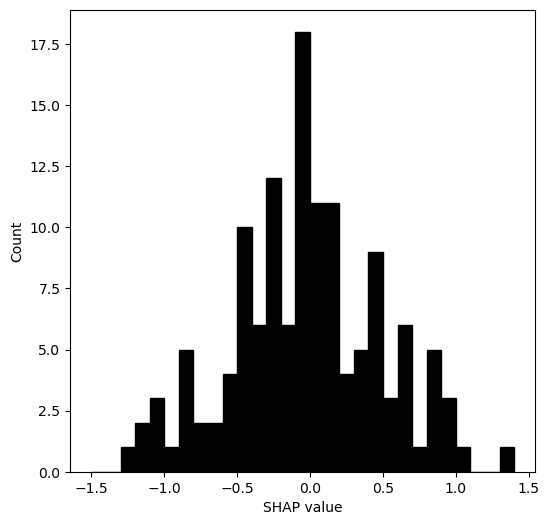

In [22]:
# Plot histogram
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
ax.hist(stroke_team_mean_shap, bins=np.arange(-1.5, 1.5, 0.1), 
        color='k', ec='k')
ax.set_xlabel('SHAP value')
ax.set_ylabel('Count')
plt.savefig(f'./output/{notebook}_{model_text}_hosp_shap_hist.jpg', dpi=300, 
            bbox_inches='tight', pad_inches=0.2)
plt.show()

### Plot histogram using same colour scheme as violin plot (for paper)
 
Code used to get colour of violin plots
Resource: https://stackoverflow.com/questions/26291479/changing-the-color-of-matplotlibs-violin-plots

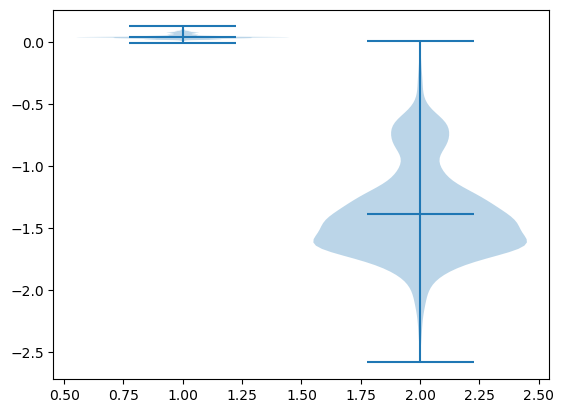

In [23]:
fig = plt.figure()
ax = fig.add_subplot()
vp = ax.violinplot(shap_per_category, showmeans=True, widths=0.9)

for vp1 in vp['bodies']:
    facecolor =  vp1.get_edgecolor()
    #facecolor = [0.12156863, 0.46666667, 0.70588235, 0.3]
    edgecolour = vp['cmeans'].get_colors()
    #edgecolour= [0.12156863, 0.46666667, 0.70588235, 1.]

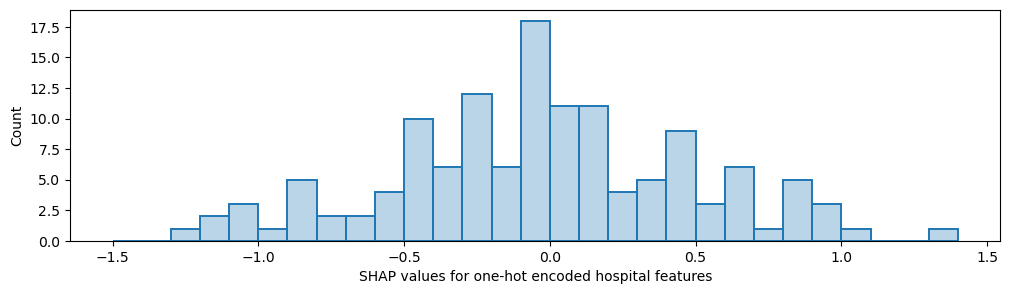

In [24]:
# Plot histogram
fig = plt.figure(figsize=(12,3))#figsize=(6,6))
ax = fig.add_subplot()
ax.hist(stroke_team_mean_shap, bins=np.arange(-1.5, 1.5, 0.1), 
        color=[0.12156863, 0.46666667, 0.70588235, 0.3], 
        ec=[0.12156863, 0.46666667, 0.70588235, 1.], linewidth=1.4)
ax.set_xlabel('SHAP values for one-hot encoded hospital features')
ax.set_ylabel('Count')
plt.savefig(f'./output/{notebook}_{model_text}_hosp_shap_hist.jpg', dpi=300, 
            bbox_inches='tight', pad_inches=0.2)
plt.show()

Log odds to odds

In [25]:
range_shap_log_odds = max(stroke_team_mean_shap) - min(stroke_team_mean_shap)
odds = math.exp(range_shap_log_odds)
print(f"There was a {round(odds,2)} fold difference in odds of receiving thrombolysis between hospitals")

There was a 13.6 fold difference in odds of receiving thrombolysis between hospitals


### How does the SHAP value for patient features compare to the thrombolysis rate of the hospital?

Create dataframe containing the hospital's IVT rate and mean SHAP value for each feature (for those patients that attend the hospital).

In [26]:
# Calculate IVT rate per hosptial
hosp_ivt_rate = data.groupby(by=["Stroke team"]).mean()["Thrombolysis"]
hosp_ivt_rate

Stroke team
AGNOF1041H    0.352468
AKCGO9726K    0.369748
AOBTM3098N    0.218803
APXEE8191H    0.226481
ATDID5461S    0.240385
                ...   
YPKYH1768F    0.246057
YQMZV4284N    0.236170
ZBVSO0975W    0.250000
ZHCLE1578P    0.223639
ZRRCV7012C    0.157670
Name: Thrombolysis, Length: 132, dtype: float64

In [27]:
unique_stroketeams_list = list(set(data["Stroke team"]))
shap_values = shap_values_extended.values

# Create dataframe with hospital along index, column per feature, containing
# mean SHAP value for feature for patients that attend that hospital
mean_values_hosp = []
for h in unique_stroketeams_list:
#    calcualte mean shap for the patients that attend hospital
    mask = data["Stroke team"] == h
    mean_values_hosp.append(np.mean(shap_values[mask],axis=0))

df_mean_shap_values_per_hosp = pd.DataFrame(data=mean_values_hosp, 
                                              index=unique_stroketeams_list,
                                              columns=feature_names_ohe)


In [28]:
df_mean_shap_values_per_hosp.head(10)

,Arrival-to-scan time,Infarction,Stroke severity,Precise onset time,Prior disability level,Use of AF anticoagulants,Onset-to-arrival time,Onset during sleep,Age,team_AGNOF1041H,...,team_XKAWN3771U,team_XPABC1435F,team_XQAGA4299B,team_XWUBX0795L,team_YEXCH8391J,team_YPKYH1768F,team_YQMZV4284N,team_ZBVSO0975W,team_ZHCLE1578P,team_ZRRCV7012C
NTPQZ0829K,-0.465076,-0.762998,-0.573246,-0.006937,-0.013715,-0.079239,-0.051014,-0.018776,-0.018424,0.001714,...,-0.008096,0.003003,0.003076,-0.003586,0.000382,0.000386,-0.001548,0.002325,-0.002203,0.002763
HYNBH3271L,-0.072362,-1.133568,-0.176291,-0.068173,-0.036493,-0.018542,-0.115929,0.008090,-0.019386,0.001379,...,-0.007413,0.001568,0.002599,-0.004367,0.000574,0.000216,-0.001616,0.001820,-0.001864,0.002898
AOBTM3098N,-0.706683,-0.827253,-0.164386,0.023894,0.008445,-0.062407,-0.079294,-0.094993,-0.040437,0.001599,...,-0.008356,0.003196,0.002574,-0.002853,0.000365,0.000367,-0.001572,0.002756,-0.001949,0.003640
ISIZF6614O,0.007661,-1.028389,-0.441657,0.008018,0.029334,-0.026940,-0.102011,0.034252,-0.041682,0.002182,...,-0.007274,0.002401,0.003248,-0.004729,0.000528,0.000308,-0.001588,0.002283,-0.001948,0.002411
MHMYL4920B,0.029865,-1.227694,-0.081311,-0.123724,0.172145,-0.054361,-0.019054,-0.016079,0.004674,0.001929,...,-0.008014,0.002501,0.003041,-0.004094,0.000485,0.000380,-0.001851,0.002181,-0.001288,0.002514
XWUBX0795L,-0.686888,-0.759391,-0.355621,0.273584,-0.075197,-0.038790,-0.116025,0.013266,0.006482,0.002824,...,-0.006968,0.002546,0.003349,0.304518,0.000509,0.000248,-0.001564,0.002621,-0.001896,0.003160
VUHVS8909F,-0.695422,-1.289697,-0.300654,-0.087929,0.012775,-0.083781,-0.055819,-0.014345,-0.054541,0.001483,...,-0.008537,0.002917,0.003116,-0.003388,0.000384,0.000360,-0.001461,0.002324,-0.002063,0.002896
PAOUI8935Z,-0.083003,-0.557687,-0.626537,-0.055085,0.087441,-0.027163,-0.028661,0.039505,-0.000064,0.004112,...,-0.008002,0.002420,0.003079,-0.004806,0.000475,0.000287,-0.001336,0.002103,-0.001596,0.002141
JRXDG8181O,-0.567706,-1.085534,-0.018899,-0.135860,0.074438,0.024057,-0.003154,-0.025301,0.030501,0.000884,...,-0.009781,0.003363,0.002937,-0.002295,0.000332,0.000430,-0.001799,0.002472,-0.002006,0.003549
LZGVG8257A,-0.467653,-1.018791,-0.078536,-0.148422,-0.140350,-0.019927,-0.096402,-0.026095,-0.028744,0.000727,...,-0.008379,0.003420,0.002982,-0.002624,0.000366,0.000471,-0.001644,0.002536,-0.002242,0.003951


In [29]:
# Join IVT rate with admissions per hosptial
df_mean_shap_values_per_hosp = df_mean_shap_values_per_hosp.join(hosp_ivt_rate)

In [30]:
df_mean_shap_values_per_hosp.head(10)

,Arrival-to-scan time,Infarction,Stroke severity,Precise onset time,Prior disability level,Use of AF anticoagulants,Onset-to-arrival time,Onset during sleep,Age,team_AGNOF1041H,...,team_XPABC1435F,team_XQAGA4299B,team_XWUBX0795L,team_YEXCH8391J,team_YPKYH1768F,team_YQMZV4284N,team_ZBVSO0975W,team_ZHCLE1578P,team_ZRRCV7012C,Thrombolysis
NTPQZ0829K,-0.465076,-0.762998,-0.573246,-0.006937,-0.013715,-0.079239,-0.051014,-0.018776,-0.018424,0.001714,...,0.003003,0.003076,-0.003586,0.000382,0.000386,-0.001548,0.002325,-0.002203,0.002763,0.349603
HYNBH3271L,-0.072362,-1.133568,-0.176291,-0.068173,-0.036493,-0.018542,-0.115929,0.008090,-0.019386,0.001379,...,0.001568,0.002599,-0.004367,0.000574,0.000216,-0.001616,0.001820,-0.001864,0.002898,0.240093
AOBTM3098N,-0.706683,-0.827253,-0.164386,0.023894,0.008445,-0.062407,-0.079294,-0.094993,-0.040437,0.001599,...,0.003196,0.002574,-0.002853,0.000365,0.000367,-0.001572,0.002756,-0.001949,0.003640,0.218803
ISIZF6614O,0.007661,-1.028389,-0.441657,0.008018,0.029334,-0.026940,-0.102011,0.034252,-0.041682,0.002182,...,0.002401,0.003248,-0.004729,0.000528,0.000308,-0.001588,0.002283,-0.001948,0.002411,0.247826
MHMYL4920B,0.029865,-1.227694,-0.081311,-0.123724,0.172145,-0.054361,-0.019054,-0.016079,0.004674,0.001929,...,0.002501,0.003041,-0.004094,0.000485,0.000380,-0.001851,0.002181,-0.001288,0.002514,0.473792
XWUBX0795L,-0.686888,-0.759391,-0.355621,0.273584,-0.075197,-0.038790,-0.116025,0.013266,0.006482,0.002824,...,0.002546,0.003349,0.304518,0.000509,0.000248,-0.001564,0.002621,-0.001896,0.003160,0.341573
VUHVS8909F,-0.695422,-1.289697,-0.300654,-0.087929,0.012775,-0.083781,-0.055819,-0.014345,-0.054541,0.001483,...,0.002917,0.003116,-0.003388,0.000384,0.000360,-0.001461,0.002324,-0.002063,0.002896,0.228534
PAOUI8935Z,-0.083003,-0.557687,-0.626537,-0.055085,0.087441,-0.027163,-0.028661,0.039505,-0.000064,0.004112,...,0.002420,0.003079,-0.004806,0.000475,0.000287,-0.001336,0.002103,-0.001596,0.002141,0.365000
JRXDG8181O,-0.567706,-1.085534,-0.018899,-0.135860,0.074438,0.024057,-0.003154,-0.025301,0.030501,0.000884,...,0.003363,0.002937,-0.002295,0.000332,0.000430,-0.001799,0.002472,-0.002006,0.003549,0.262295
LZGVG8257A,-0.467653,-1.018791,-0.078536,-0.148422,-0.140350,-0.019927,-0.096402,-0.026095,-0.028744,0.000727,...,0.003420,0.002982,-0.002624,0.000366,0.000471,-0.001644,0.002536,-0.002242,0.003951,0.270880


Plot SHAP value for patient features (mean for those instances that attend the hospital) vs hospital IVT rate

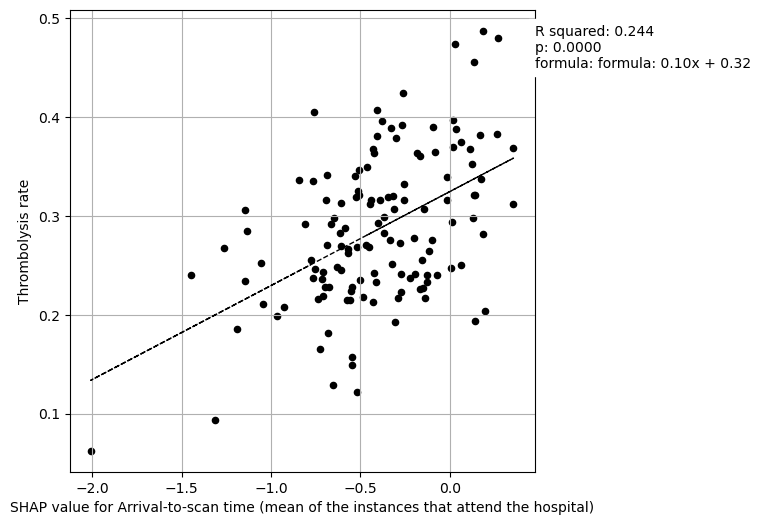

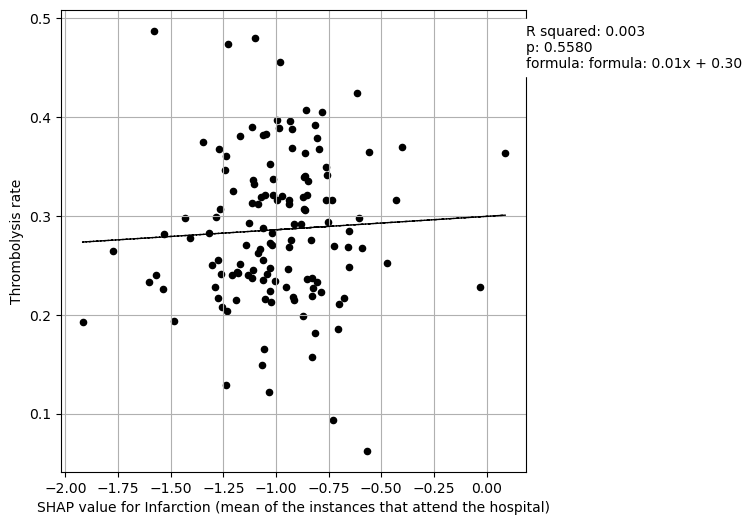

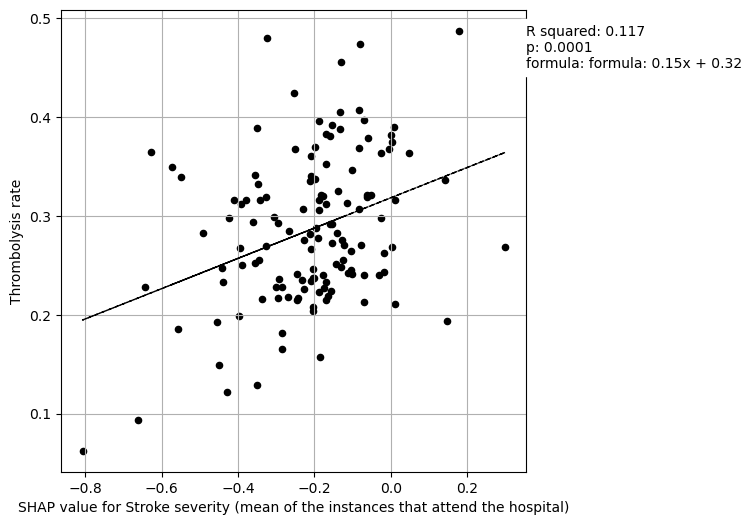

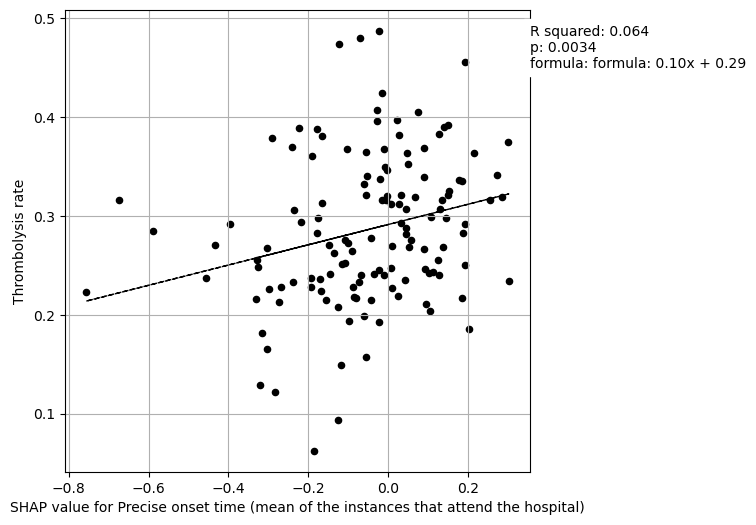

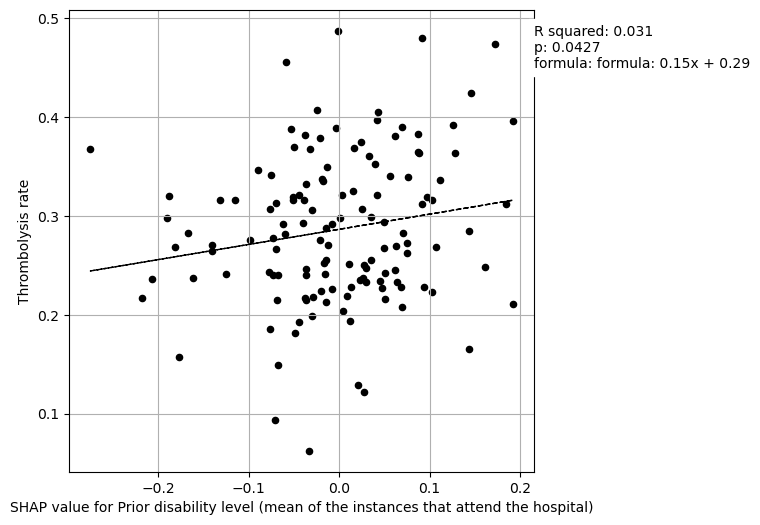

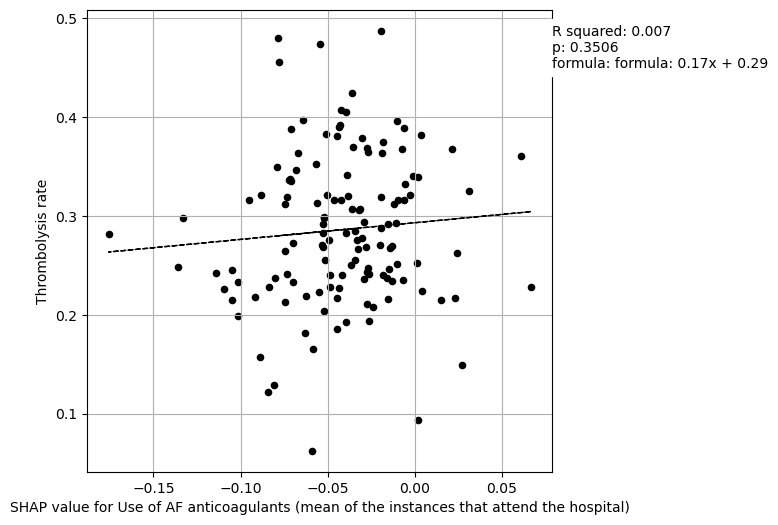

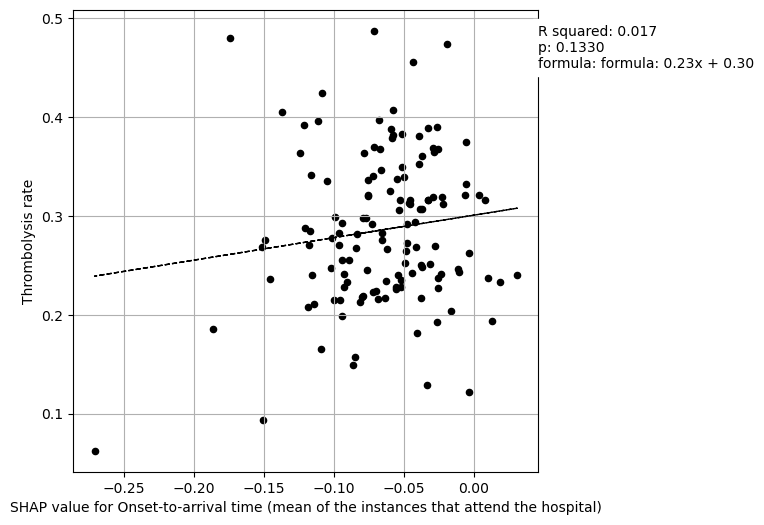

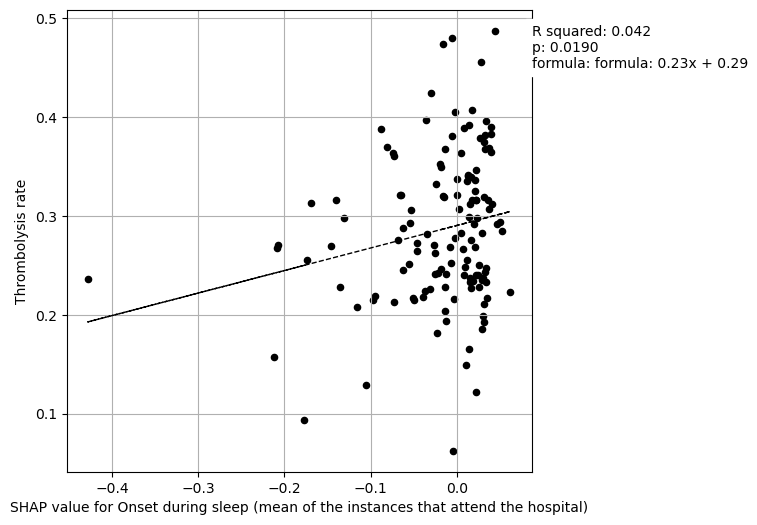

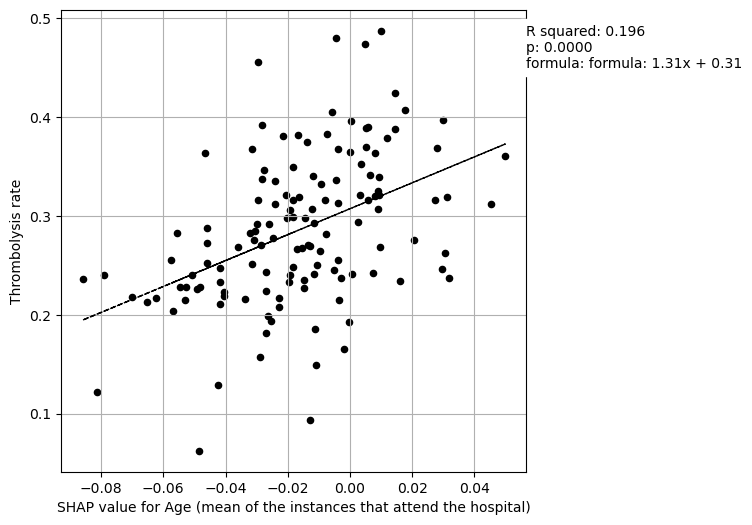

In [31]:
features_to_plot = ['Arrival-to-scan time','Infarction','Stroke severity',
                    'Precise onset time','Prior disability level',
                    'Use of AF anticoagulants','Onset-to-arrival time',
                    'Onset during sleep','Age']

for feat in features_to_plot: 
    # Setup data for chart
    x = df_mean_shap_values_per_hosp[feat]
    y = df_mean_shap_values_per_hosp['Thrombolysis']

    # Fit a regression line to the x2 points
    slope, intercept, r_value, p_value, std_err = \
        stats.linregress(x, y)
    r_square = r_value ** 2
    y_pred = intercept + (x * slope)

    # Create scatter plot with regression line
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(1,1,1)

    ax.scatter(x, y, color = 'k', marker="o", s=20)
    ax.plot (x, y_pred, color = 'k', linestyle='--', linewidth=1)

    ax.set_xlabel(f"SHAP value for {feat} "
                  f"(mean of the instances that attend the hospital)")
    ax.set_ylabel('Thrombolysis rate')

#    ax.set_ylim(0, 0.5)
#    ax.set_xlim(-1.5, 1.5)


    plt.grid()

    # Add  text
    f = ('formula: ' + str("{:.2f}".format(slope)) + 'x + ' + 
          str("{:.2f}".format(intercept)))
    text = (f'R squared: {r_square:.3f}\np: '
             f'{p_value:0.4f}\nformula: {f}')
    x_axis_max = ax.get_xlim()[1]
    ax.text(x_axis_max, 0.45, text, 
             bbox=dict(facecolor='white', edgecolor='white'))

    # Save figure

#    plt.savefig(f'./output/{notebook}_{model_text}'
#                f'_attended_hosp_shap_value.jpg', 
#                dpi=300, bbox_inches='tight', pad_inches=0.2)
    plt.show()

In [32]:
X = df_mean_shap_values_per_hosp[features_to_plot]
y = df_mean_shap_values_per_hosp['Thrombolysis']

regr = linear_model.LinearRegression()
regr.fit(X, y)

df_reg_coeff = pd.DataFrame(data = regr.coef_, index = features_to_plot, columns=["coeff"])
df_reg_coeff

,coeff
Arrival-to-scan time,0.079886
Infarction,0.063246
Stroke severity,0.111067
Precise onset time,0.046224
Prior disability level,0.050308
Use of AF anticoagulants,0.036244
Onset-to-arrival time,-0.088946
Onset during sleep,0.074848
Age,0.785148


In [33]:
y_pred = regr.predict(X)

# Fit a regression line to the obs and pred IVT use
slope, intercept, r_value, p_value, std_err = \
    stats.linregress(y, y_pred)
r_square = r_value ** 2
y_pred = intercept + (y * slope)
print(r_square)

0.4665846040184782


Add in the mean SHAP value for the hospital feature (already calculated in notebook 03c)

In [34]:
filename = (f'./output/03c_{model_text}'
            f'_attended_hosp_shap_value.csv')
df_hosp_shap = pd.read_csv(filename)#[['shap_mean_sv','Thrombolysis']]
df_hosp_shap = df_hosp_shap.set_index("hospital")

In [35]:
df_mean_shap_values_per_hosp = df_mean_shap_values_per_hosp.join(df_hosp_shap, rsuffix="h_")
df_mean_shap_values_per_hosp

,Arrival-to-scan time,Infarction,Stroke severity,Precise onset time,Prior disability level,Use of AF anticoagulants,Onset-to-arrival time,Onset during sleep,Age,team_AGNOF1041H,...,team_YEXCH8391J,team_YPKYH1768F,team_YQMZV4284N,team_ZBVSO0975W,team_ZHCLE1578P,team_ZRRCV7012C,Thrombolysis,shap_mean_sv,Thrombolysish_,shap_mean_me
NTPQZ0829K,-0.465076,-0.762998,-0.573246,-0.006937,-0.013715,-0.079239,-0.051014,-0.018776,-0.018424,0.001714,...,0.000382,0.000386,-0.001548,0.002325,-0.002203,0.002763,0.349603,0.917956,0.349603,1.006841
HYNBH3271L,-0.072362,-1.133568,-0.176291,-0.068173,-0.036493,-0.018542,-0.115929,0.008090,-0.019386,0.001379,...,0.000574,0.000216,-0.001616,0.001820,-0.001864,0.002898,0.240093,-0.623077,0.240093,-0.532887
AOBTM3098N,-0.706683,-0.827253,-0.164386,0.023894,0.008445,-0.062407,-0.079294,-0.094993,-0.040437,0.001599,...,0.000365,0.000367,-0.001572,0.002756,-0.001949,0.003640,0.218803,-0.401549,0.218803,-0.390772
ISIZF6614O,0.007661,-1.028389,-0.441657,0.008018,0.029334,-0.026940,-0.102011,0.034252,-0.041682,0.002182,...,0.000528,0.000308,-0.001588,0.002283,-0.001948,0.002411,0.247826,-0.501235,0.247826,-0.499415
MHMYL4920B,0.029865,-1.227694,-0.081311,-0.123724,0.172145,-0.054361,-0.019054,-0.016079,0.004674,0.001929,...,0.000485,0.000380,-0.001851,0.002181,-0.001288,0.002514,0.473792,0.933300,0.473792,0.964972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
OQYTM8444L,-0.183703,-0.862155,0.048012,0.046188,0.088399,-0.018978,-0.124379,-0.073665,0.008024,0.002041,...,0.000502,0.000317,-0.001721,0.002667,-0.001832,0.003228,0.364017,-0.098254,0.364017,-0.113462
YEXCH8391J,-0.544563,-0.031423,-0.642856,-0.269504,0.093702,0.066832,-0.051718,0.026094,-0.052784,-0.000593,...,-0.275317,0.000448,-0.001451,0.001993,-0.001871,0.002455,0.228188,-0.275317,0.228188,-0.340365
IUMNL9626U,-1.191899,-0.707900,-0.556744,0.202532,-0.077063,-0.044510,-0.186686,0.028765,-0.011223,0.001455,...,0.000428,0.000353,-0.001492,0.002573,-0.002082,0.002913,0.185751,-0.847366,0.185751,-0.814281
YQMZV4284N,-0.716863,-0.851503,-0.292017,-0.170293,-0.207392,-0.029464,-0.145403,-0.428263,-0.085955,0.001169,...,0.000369,0.000393,0.388534,0.002115,-0.002380,0.003795,0.236170,0.388534,0.236170,0.503184


In [36]:
features_to_plot = ['Arrival-to-scan time','Infarction','Stroke severity',
                    'Precise onset time','Prior disability level',
                    'Use of AF anticoagulants','Onset-to-arrival time',
                    'Onset during sleep','Age', 'shap_mean_sv']
X = df_mean_shap_values_per_hosp[features_to_plot]
y = df_mean_shap_values_per_hosp['Thrombolysis']

regr = linear_model.LinearRegression()
regr.fit(X, y)

df_reg_coeff = pd.DataFrame(data = regr.coef_, index = features_to_plot, columns=["coeff"])
df_reg_coeff

,coeff
Arrival-to-scan time,0.066249
Infarction,0.034880
Stroke severity,0.089651
Precise onset time,0.116825
Prior disability level,0.090232
Use of AF anticoagulants,0.129920
Onset-to-arrival time,-0.098246
Onset during sleep,0.068122
Age,0.178001
shap_mean_sv,0.109368


In [37]:
y_pred = regr.predict(X)

# Fit a regression line to the obs and pred IVT use
slope, intercept, r_value, p_value, std_err = \
    stats.linregress(y, y_pred)
r_square = r_value ** 2
y_pred = intercept + (y * slope)
print(r_square)

0.9327469999907462


### Regression on patient characteristics vs IVT rate

In [38]:
features_to_plot = ['Infarction','Stroke severity',
                    'Precise onset time','Prior disability level',
                    'Use of AF anticoagulants','Onset-to-arrival time',
                    'Onset during sleep','Age']

X = df_mean_shap_values_per_hosp[features_to_plot]
y = df_mean_shap_values_per_hosp['Thrombolysis']

regr = linear_model.LinearRegression()
regr.fit(X, y)

df_reg_coeff = pd.DataFrame(data = regr.coef_, index = features_to_plot, columns=["coeff"])
df_reg_coeff

,coeff
Infarction,0.041041
Stroke severity,0.136061
Precise onset time,0.060148
Prior disability level,0.047839
Use of AF anticoagulants,-0.058462
Onset-to-arrival time,0.071181
Onset during sleep,0.111865
Age,1.062042


In [39]:
y_pred = regr.predict(X)

# Fit a regression line to the obs and pred IVT use
slope, intercept, r_value, p_value, std_err = \
    stats.linregress(y, y_pred)
r_square = r_value ** 2
y_pred = intercept + (y * slope)
print(r_square)

0.34101869675915536


### Regression on hospital processes vs IVT rate

In [40]:
features_to_plot = ['Arrival-to-scan time','shap_mean_sv']
X = df_mean_shap_values_per_hosp[features_to_plot]
y = df_mean_shap_values_per_hosp['Thrombolysis']

regr = linear_model.LinearRegression()
regr.fit(X, y)

df_reg_coeff = pd.DataFrame(data = regr.coef_, index = features_to_plot, columns=["coeff"])
df_reg_coeff

,coeff
Arrival-to-scan time,0.079994
shap_mean_sv,0.106429


In [41]:
y_pred = regr.predict(X)

# Fit a regression line to the obs and pred IVT use
slope, intercept, r_value, p_value, std_err = \
    stats.linregress(y, y_pred)
r_square = r_value ** 2
y_pred = intercept + (y * slope)
print(r_square)

0.7498380635030895


Correlation between IVT rate and proportion ischemeic

In [42]:
# Calculate IVT rate per hosptial
hosp_isch_rate = data.groupby(by=["Stroke team"]).mean()["Infarction"]
hosp_isch_rate# = hosp_isch_rate.set_index("Stroke team")

Stroke team
AGNOF1041H    0.846154
AKCGO9726K    0.916667
AOBTM3098N    0.866667
APXEE8191H    0.783972
ATDID5461S    0.817308
                ...   
YPKYH1768F    0.854890
YQMZV4284N    0.859574
ZBVSO0975W    0.821759
ZHCLE1578P    0.869898
ZRRCV7012C    0.863636
Name: Infarction, Length: 132, dtype: float64

In [43]:
hosp_ivt_rate

Stroke team
AGNOF1041H    0.352468
AKCGO9726K    0.369748
AOBTM3098N    0.218803
APXEE8191H    0.226481
ATDID5461S    0.240385
                ...   
YPKYH1768F    0.246057
YQMZV4284N    0.236170
ZBVSO0975W    0.250000
ZHCLE1578P    0.223639
ZRRCV7012C    0.157670
Name: Thrombolysis, Length: 132, dtype: float64

In [44]:
hosp_isch_ivt_rate = pd.concat([hosp_isch_rate, hosp_ivt_rate], axis=1)
hosp_isch_ivt_rate

,Infarction,Thrombolysis
Stroke team,,
AGNOF1041H,0.846154,0.352468
AKCGO9726K,0.916667,0.369748
AOBTM3098N,0.866667,0.218803
APXEE8191H,0.783972,0.226481
ATDID5461S,0.817308,0.240385
...,...,...
YPKYH1768F,0.854890,0.246057
YQMZV4284N,0.859574,0.236170
ZBVSO0975W,0.821759,0.250000


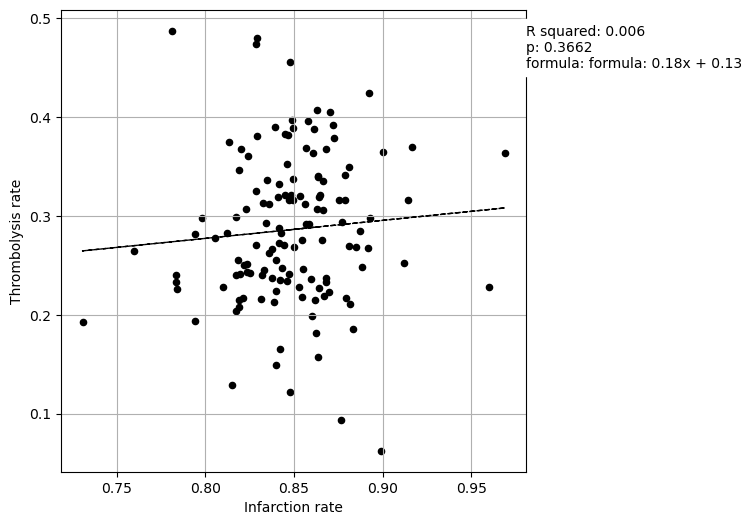

In [45]:
# Setup data for chart
x = hosp_isch_ivt_rate['Infarction']
y = hosp_isch_ivt_rate['Thrombolysis']

# Fit a regression line to the x2 points
slope, intercept, r_value, p_value, std_err = \
    stats.linregress(x, y)
r_square = r_value ** 2
y_pred = intercept + (x * slope)

# Create scatter plot with regression line
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)

ax.scatter(x, y, color = 'k', marker="o", s=20)
ax.plot (x, y_pred, color = 'k', linestyle='--', linewidth=1)

ax.set_xlabel(f"Infarction rate")
ax.set_ylabel('Thrombolysis rate')

plt.grid()

# Add  text
f = ('formula: ' + str("{:.2f}".format(slope)) + 'x + ' + 
      str("{:.2f}".format(intercept)))
text = (f'R squared: {r_square:.3f}\np: '
         f'{p_value:0.4f}\nformula: {f}')

x_axis_max = ax.get_xlim()[1]
ax.text(x_axis_max, 0.45, text, 
         bbox=dict(facecolor='white', edgecolor='white'))

    # Save figure

#    plt.savefig(f'./output/{notebook}_{model_text}'
#                f'_attended_hosp_shap_value.jpg', 
#                dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.show()

## Repeat using SHAP main effect

Read in SHAP interactions from notebook 03b

In [46]:
%%time

filename = f'./output/03b_{model_text}_shap_interaction_array.p'
file_exists = exists(filename)

if file_exists:
    # Load SHAP interaction
    with open(filename, 'rb') as filehandler:
        shap_interaction = pickle.load(filehandler)
else:
    print("Run notebook 03b_xgb_shap_values_focus_on_ohe_hospitals.ipynb")

CPU times: user 2.75 ms, sys: 1.74 s, total: 1.75 s
Wall time: 1.74 s


In [47]:
shap_interaction.shape

(88792, 141, 141)

Get main effect for each feature for each patient

In [48]:
shap_main_effects = []
hospitals_ohe = X_data.filter(regex='^team',axis=1).columns

# For each patient
for i in range(shap_interaction.shape[0]):
# Get the main effect value for each of the features
    main_effects = np.diagonal(shap_interaction[i])
    shap_main_effects.append(main_effects)

# Put in dataframe with features as column title
df_hosp_shap_main_effects = pd.DataFrame(shap_main_effects, columns=feature_names_ohe)

# Include Stroke team that each instance attended
#df_hosp_shap_main_effects["Stroke team"] = data["Stroke team"]

# Store the sum of the SHAP values (for all of the hospital features)
#df_hosp_shap_main_effects["All stroke teams"] = df_hosp_shap_main_effects[hospitals_ohe].sum(axis=1)

shap_of_team_attended = []
# For each patient
for i in range(shap_interaction.shape[0]):
    shap_of_team_attended.append(df_hosp_shap_main_effects[f"team_{data['Stroke team'].loc[i]}"].loc[i])
# Store the SHAP values for the hospital attended
df_hosp_shap_main_effects["Stroke team"] = shap_of_team_attended

# Store the sum of the SHAP values for all of the hospitals not attended
#df_hosp_shap_main_effects["Not attended stroke teams"] = (
#                    df_hosp_shap_main_effects["All stroke teams"] - 
#                    df_hosp_shap_main_effects["Attended stroke team"])

# remove thrombolysis
# Stroke team contians SHAP main effect for stroke team attended
feature_names_keep = feature_names[0:-1]
df_hosp_shap_main_effects = df_hosp_shap_main_effects[feature_names_keep]

In [49]:
df_hosp_shap_main_effects.head()

,Arrival-to-scan time,Infarction,Stroke severity,Precise onset time,Prior disability level,Stroke team,Use of AF anticoagulants,Onset-to-arrival time,Onset during sleep,Age
0,0.676277,0.338386,0.862582,0.430773,0.322120,-0.187852,0.135322,-0.441546,0.042960,0.231744
1,0.447184,0.339734,0.297246,0.434184,0.331810,-0.580359,0.138708,0.165874,0.048222,0.235642
2,-2.979032,0.321163,-1.694299,0.420702,0.379625,-1.192582,0.148083,0.001259,0.039560,0.125615
3,0.336959,-8.517138,0.747195,0.435908,0.358994,0.977001,0.161105,0.071381,0.043983,0.042129
4,0.847006,0.340107,0.851986,0.437559,0.336050,0.070702,0.143654,0.160698,0.044551,0.053406


In [50]:
unique_stroketeams_list = list(set(data["Stroke team"]))
#shap_values = shap_values_extended.values

# Create dataframe with hospital along index, column per feature, containing
# mean SHAP main effect for feature for patients that attend that hospital
mean_shap_main_effect_hosp = []
for h in unique_stroketeams_list:
#    calcualte mean shap for the patients that attend hospital
    mask = data["Stroke team"] == h
    mean_shap_main_effect_hosp.append(np.mean(df_hosp_shap_main_effects[mask],axis=0))

df_mean_shap_main_effect_per_hosp = pd.DataFrame(data=mean_shap_main_effect_hosp, 
                                                   index=unique_stroketeams_list,
                                                   columns=feature_names_keep)

In [51]:
df_mean_shap_main_effect_per_hosp

,Arrival-to-scan time,Infarction,Stroke severity,Precise onset time,Prior disability level,Stroke team,Use of AF anticoagulants,Onset-to-arrival time,Onset during sleep,Age
NTPQZ0829K,-0.450357,-0.712726,-0.516609,-0.017206,-0.034325,1.006841,-0.064888,-0.033698,-0.008446,-0.028812
HYNBH3271L,0.014940,-1.143917,-0.154469,-0.044538,-0.031993,-0.532887,-0.024391,-0.078583,0.016211,-0.023081
AOBTM3098N,-0.781391,-0.837082,-0.149835,0.049635,0.012531,-0.390772,-0.062263,-0.046660,-0.067334,-0.044815
ISIZF6614O,0.016311,-1.039566,-0.407234,0.004790,0.031238,-0.499415,-0.022526,-0.080625,0.039919,-0.049136
MHMYL4920B,0.065949,-1.179195,-0.081282,-0.143891,0.161415,0.964972,-0.064387,-0.010099,-0.010181,-0.001964
...,...,...,...,...,...,...,...,...,...,...
OQYTM8444L,-0.175588,-0.893047,0.039105,0.047279,0.057429,-0.113462,-0.032074,-0.107137,-0.051401,-0.007509
YEXCH8391J,-0.683667,-0.016764,-0.729251,-0.305637,0.081066,-0.340364,0.063147,-0.020227,0.026388,-0.038568
IUMNL9626U,-1.202068,-0.696896,-0.542578,0.238191,-0.152271,-0.814282,-0.035247,-0.065188,0.035691,-0.023318
YQMZV4284N,-0.710008,-0.904079,-0.290546,-0.165230,-0.215135,0.503183,-0.041543,-0.094831,-0.366518,-0.054738


Add thrombolysis rate

In [52]:
# Join IVT rate with admissions per hosptial
df_mean_shap_main_effect_per_hosp = df_mean_shap_main_effect_per_hosp.join(hosp_ivt_rate)
df_mean_shap_main_effect_per_hosp

,Arrival-to-scan time,Infarction,Stroke severity,Precise onset time,Prior disability level,Stroke team,Use of AF anticoagulants,Onset-to-arrival time,Onset during sleep,Age,Thrombolysis
NTPQZ0829K,-0.450357,-0.712726,-0.516609,-0.017206,-0.034325,1.006841,-0.064888,-0.033698,-0.008446,-0.028812,0.349603
HYNBH3271L,0.014940,-1.143917,-0.154469,-0.044538,-0.031993,-0.532887,-0.024391,-0.078583,0.016211,-0.023081,0.240093
AOBTM3098N,-0.781391,-0.837082,-0.149835,0.049635,0.012531,-0.390772,-0.062263,-0.046660,-0.067334,-0.044815,0.218803
ISIZF6614O,0.016311,-1.039566,-0.407234,0.004790,0.031238,-0.499415,-0.022526,-0.080625,0.039919,-0.049136,0.247826
MHMYL4920B,0.065949,-1.179195,-0.081282,-0.143891,0.161415,0.964972,-0.064387,-0.010099,-0.010181,-0.001964,0.473792
...,...,...,...,...,...,...,...,...,...,...,...
OQYTM8444L,-0.175588,-0.893047,0.039105,0.047279,0.057429,-0.113462,-0.032074,-0.107137,-0.051401,-0.007509,0.364017
YEXCH8391J,-0.683667,-0.016764,-0.729251,-0.305637,0.081066,-0.340364,0.063147,-0.020227,0.026388,-0.038568,0.228188
IUMNL9626U,-1.202068,-0.696896,-0.542578,0.238191,-0.152271,-0.814282,-0.035247,-0.065188,0.035691,-0.023318,0.185751
YQMZV4284N,-0.710008,-0.904079,-0.290546,-0.165230,-0.215135,0.503183,-0.041543,-0.094831,-0.366518,-0.054738,0.236170


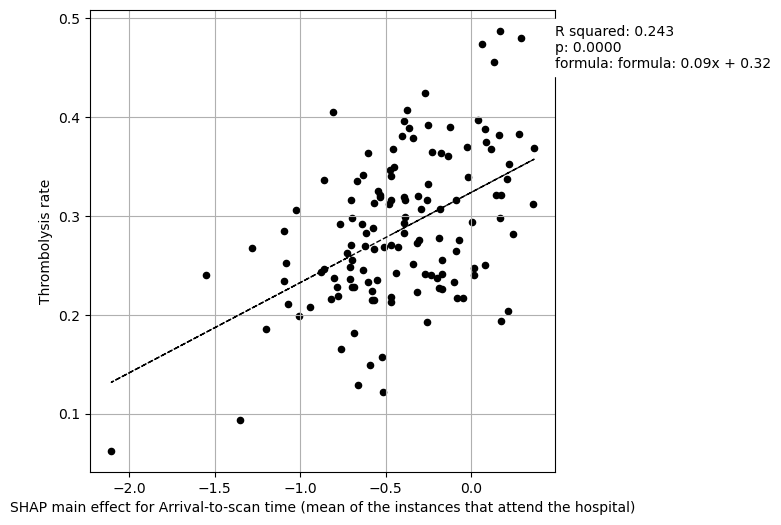

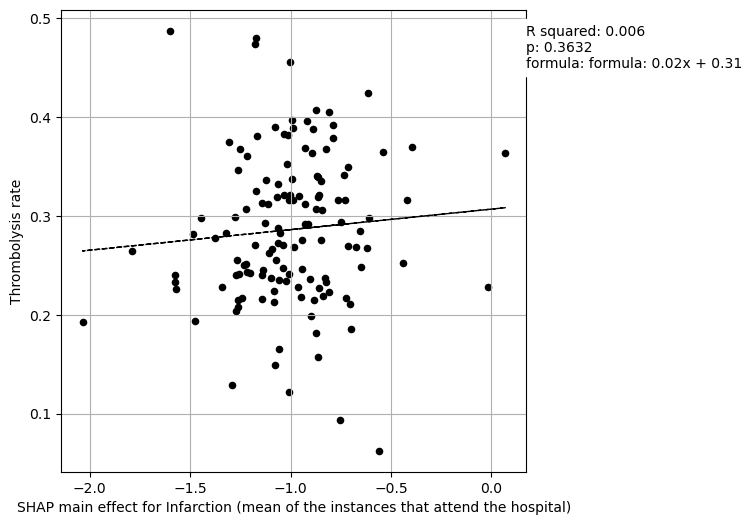

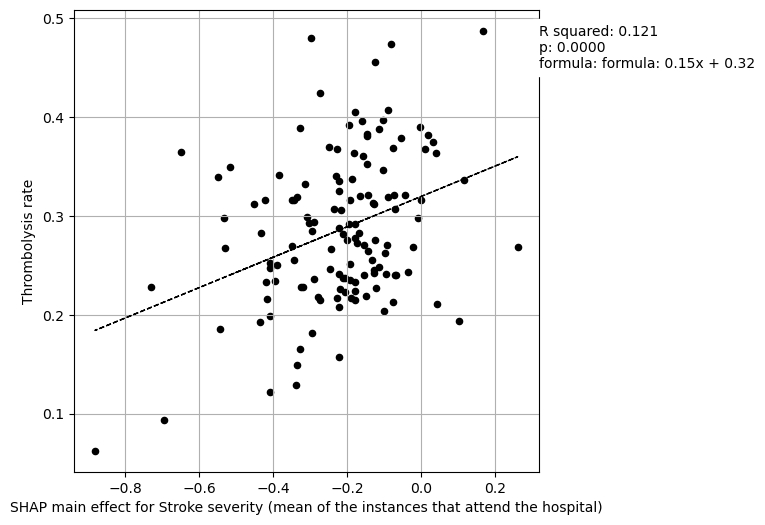

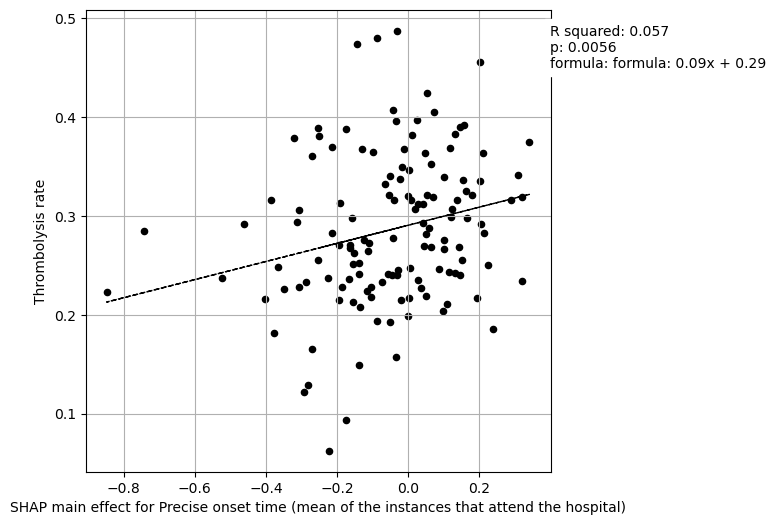

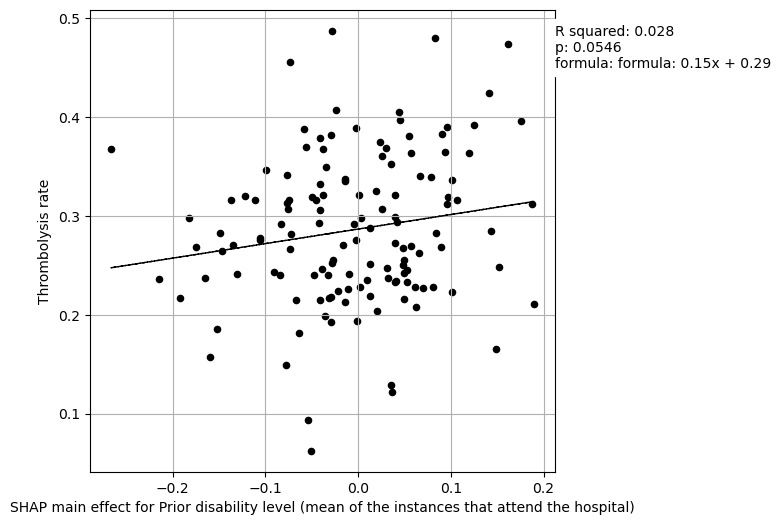

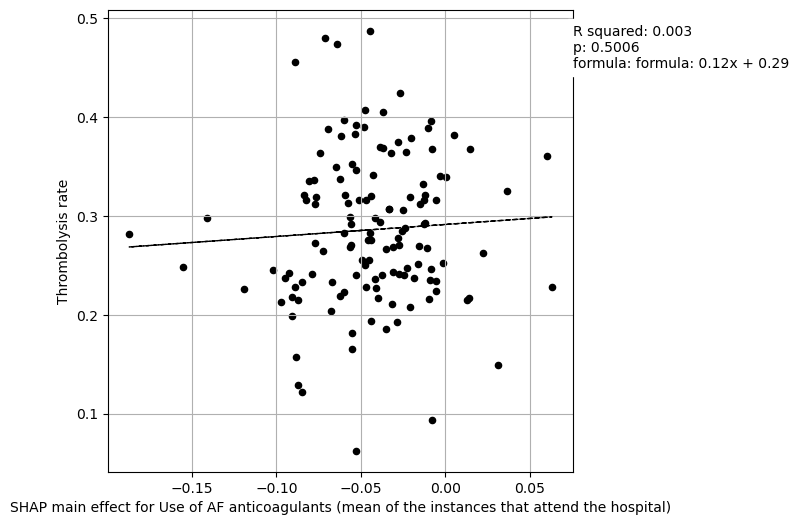

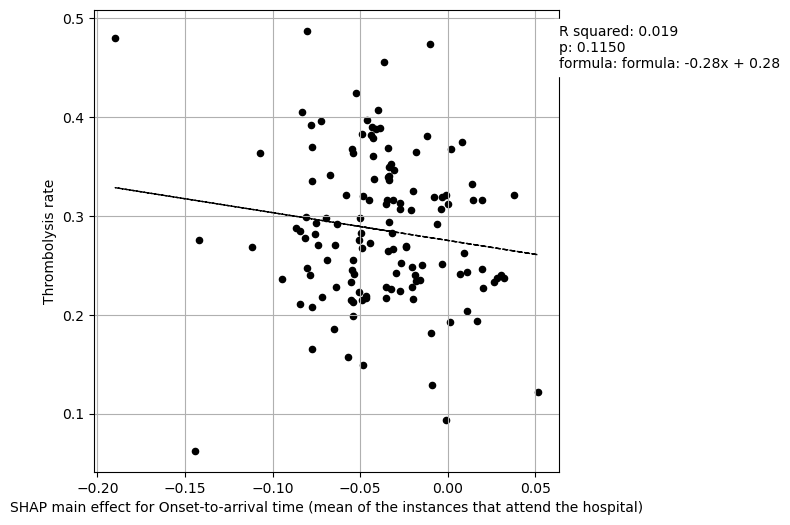

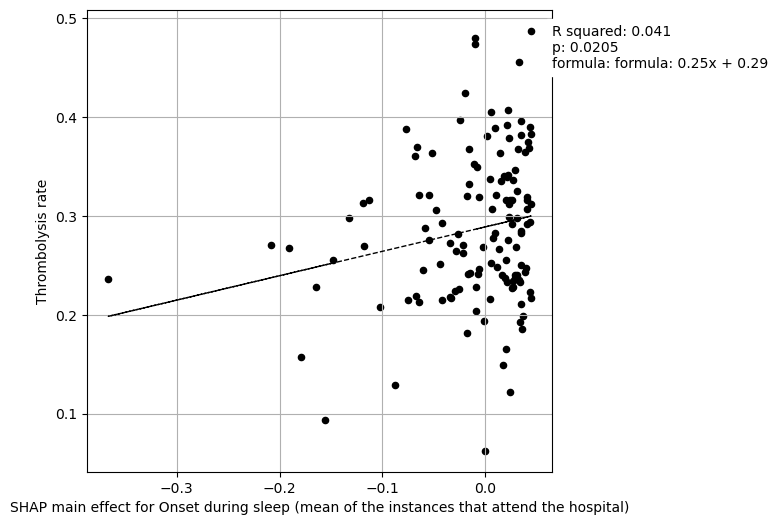

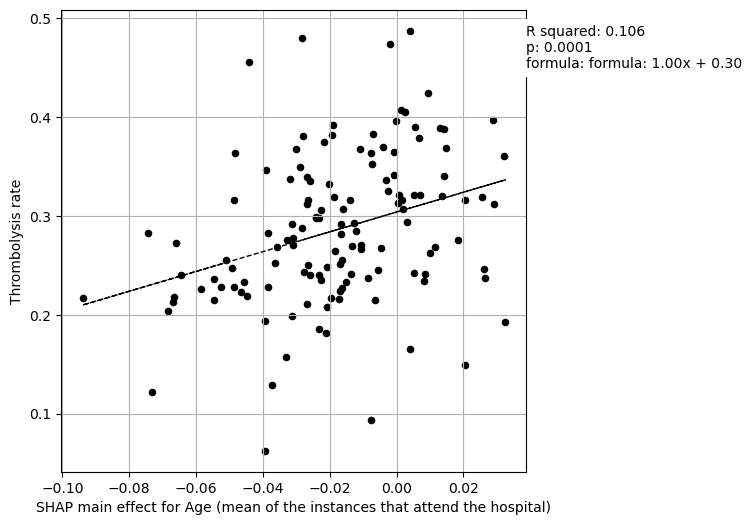

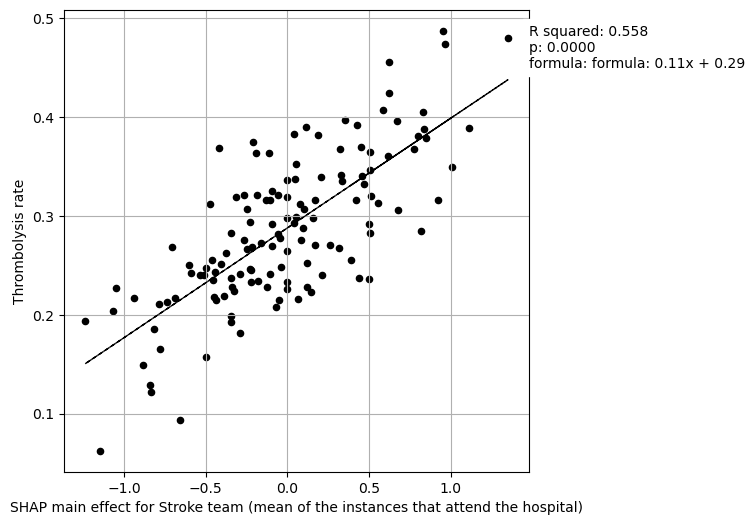

In [53]:
features_to_plot = ['Arrival-to-scan time','Infarction','Stroke severity',
                    'Precise onset time','Prior disability level',
                    'Use of AF anticoagulants','Onset-to-arrival time',
                    'Onset during sleep','Age', 'Stroke team']

for feat in features_to_plot: 
    # Setup data for chart
    x = df_mean_shap_main_effect_per_hosp[feat]
    y = df_mean_shap_main_effect_per_hosp['Thrombolysis']

    # Fit a regression line to the x2 points
    slope, intercept, r_value, p_value, std_err = \
        stats.linregress(x, y)
    r_square = r_value ** 2
    y_pred = intercept + (x * slope)

    # Create scatter plot with regression line
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(1,1,1)

    ax.scatter(x, y, color = 'k', marker="o", s=20)
    ax.plot (x, y_pred, color = 'k', linestyle='--', linewidth=1)

    ax.set_xlabel(f"SHAP main effect for {feat} "
                  f"(mean of the instances that attend the hospital)")
    ax.set_ylabel('Thrombolysis rate')

#    ax.set_ylim(0, 0.5)
#    ax.set_xlim(-1.5, 1.5)


    plt.grid()

    # Add  text
    f = ('formula: ' + str("{:.2f}".format(slope)) + 'x + ' + 
          str("{:.2f}".format(intercept)))
    text = (f'R squared: {r_square:.3f}\np: '
             f'{p_value:0.4f}\nformula: {f}')
    
    x_axis_max = ax.get_xlim()[1]
    ax.text(x_axis_max, 0.45, text,
             bbox=dict(facecolor='white', edgecolor='white'))

    # Save figure

#    plt.savefig(f'./output/{notebook}_{model_text}'
#                f'_attended_hosp_shap_value.jpg', 
#                dpi=300, bbox_inches='tight', pad_inches=0.2)
    plt.show()

### Regression on patient characteristics vs IVT rate

In [54]:
features_to_plot = ['Infarction','Stroke severity',
                    'Precise onset time','Prior disability level',
                    'Use of AF anticoagulants','Onset-to-arrival time',
                    'Onset during sleep','Age']

X = df_mean_shap_main_effect_per_hosp[features_to_plot]
y = df_mean_shap_main_effect_per_hosp['Thrombolysis']

regr = linear_model.LinearRegression()
regr.fit(X, y)

df_reg_coeff = pd.DataFrame(data = regr.coef_, index = features_to_plot, columns=["coeff"])
df_reg_coeff

,coeff
Infarction,0.044203
Stroke severity,0.161030
Precise onset time,0.052356
Prior disability level,0.041763
Use of AF anticoagulants,0.004634
Onset-to-arrival time,-0.332927
Onset during sleep,0.216030
Age,0.793499


In [55]:
y_pred = regr.predict(X)

# Fit a regression line to the obs and pred IVT use
slope, intercept, r_value, p_value, std_err = \
    stats.linregress(y, y_pred)
r_square = r_value ** 2
y_pred = intercept + (y * slope)
print(r_square)

0.3234011211208743


### Regression on hospital processes vs IVT rate

In [56]:
features_to_plot = ['Arrival-to-scan time','Stroke team']
X = df_mean_shap_main_effect_per_hosp[features_to_plot]
y = df_mean_shap_main_effect_per_hosp['Thrombolysis']

regr = linear_model.LinearRegression()
regr.fit(X, y)

df_reg_coeff = pd.DataFrame(data = regr.coef_, index = features_to_plot, columns=["coeff"])
df_reg_coeff

,coeff
Arrival-to-scan time,0.078443
Stroke team,0.104766


In [57]:
y_pred = regr.predict(X)

# Fit a regression line to the obs and pred IVT use
slope, intercept, r_value, p_value, std_err = \
    stats.linregress(y, y_pred)
r_square = r_value ** 2
y_pred = intercept + (y * slope)
print(r_square)

0.7360112077789019


We saw an unexpected high correlation (0.44) between hosptial IVT rate and SHAP value for infarction (even though the SHAP value is small).

When looked at main effect instead the correlation was lost.

So it seems the correlation came from some leakage of hospital SHAP interactions into the Infarction SHAP value,

So far we have looked at the two extremes: SHAP values (includes all interactions) and main effect (no ineractions).

Since we're splitting the features into two groups (hospital ones, and patient ones) to fit a multiple regressions on, let's only include the SHAP interactions for the features that are in the same regression. So only the main effect and the interactions that are with the other features in the multiple regression.

This way we have a bunch of SHAP interactions that are between the hostpial features and patient features. For completeness, fit a multiple regression on these.

Get main effect and interactions for features in multiple regression group, for each feature for each patient.

Do this in the next notebook: 03e_xgb_shap_values_vs_feature_values_multiple_regression.ipynb